In [1]:
import pandas as pd
from dgt import process_data
from grafo import Grafo
from math import sqrt
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import re

In [139]:
VELOCIDADES_CALLES={"AUTOVIA":100,"AVENIDA":90,"CARRETERA":70,"CALLEJON":30,"CAMINO":30,"ESTACION DE METRO":20,"PASADIZO":20,"PLAZUELA":20,"COLONIA":20}
VELOCIDAD_CALLES_ESTANDAR=50

df_cruces, df_direcc = process_data("data/cruces.csv", "data/direcciones.csv")
regex_direcciones = r"([A-ZÁÉÍÓÚÜ]+)\s*(DEL|DE LA|DE LOS|DE LAS|DE)?\s+([A-ZÁÉÍÓÚÜ]-[0-9]+|[A-ZÁÉÍÓÚÜ\s]+),?\s+(NUM|KM)?\s?([0-9]+)([A-Z]{0,2})"

from callejero import Cruce, Calle, filtrar_por_radios, dist

def generar_grafos():
    # 1500 centímetros = 15 metros, se considera que un cruce está dentro del radio de otro si está a
    # menos de 15 metros de distancia según las observaciones
    coordenadas_limpias = filtrar_por_radios(1500)

    # Creamos los cruces
    cruces = {}
    for coordenada in coordenadas_limpias:
        cruces[coordenada] = Cruce(coordenada[0], coordenada[1])
    list_cruces:list[Cruce] = list(cruces.values())

    # Creamos las calles
    calles_dict = {}
    calles = []
    for cruce in list_cruces: # Escogemos los cruces
        for calle in cruce.calles: # Escogemos las calles de cada cruce
            if calle not in calles: # Si la calle no está en la lista de calles, la añadimos
                calles.append(calle)
                calles_dict[calle] = Calle(calle)
    calles = [Calle(calle) for calle in calles] # Creamos los objetos calle

    # Creamos el grafo  
    grafo_d = Grafo(False)
    grafo_t = Grafo(False)

    # Añadir vértices al grafo
    for cruce in list_cruces:
        grafo_d.agregar_vertice(cruce)
        grafo_t.agregar_vertice(cruce)

    # Para las aristas, se añaden las calles que conectan dos cruces como aristas del grafo
    for calle in calles:
        calle.ordenar_cruces()
        cruces_calle = calle.cruces
        for i in range(len(cruces_calle)):
            if i != len(cruces_calle) - 1:
                coords_actual, coords_siguiente = cruces_calle[i], cruces_calle[i+1]
                cruce_actual, cruce_siguiente = cruces[coords_actual], cruces[coords_siguiente]

                distancia = dist(coords_actual, coords_siguiente)
                tiempo = ((distancia / 100000) / calle.get_velocidad()) * 60 # En minutos

                grafo_d.agregar_arista(cruce_actual, cruce_siguiente, None, distancia)
                grafo_t.agregar_arista(cruce_actual, cruce_siguiente, None, tiempo)
    
    return grafo_d, grafo_t, cruces, calles_dict

def mostrar_ruta(grafo:Grafo, camino_min_aristas:list):
    G = grafo.convertir_a_NetworkX()

    pos = {}
    for cruce in grafo.lista_vertices():
        pos[cruce] = (cruce.coord_x, cruce.coord_y)

    nx.draw_networkx_nodes(G, pos=pos, node_size=1)
    nx.draw_networkx_edges(G, pos=pos, width=0.5, edge_color="black")
    nx.draw_networkx_edges(G, pos=pos, arrows=True, edgelist=camino_min_aristas, edge_color='r', width=10.0)
    plt.show()

grafo_d, grafo_t, cruces, calles_dict = generar_grafos()

c:\unibersida\segundo\discreta\practica1\Practica_3\dgt.py:40: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path, encoding="iso-8859-1", delimiter=";")
c:\unibersida\segundo\discreta\practica1\Practica_3\dgt.py:108: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  literal_splitted[columnas] = literal_splitted['Literal de numeracion'].apply(lambda x: pd.Series(listas(x)))


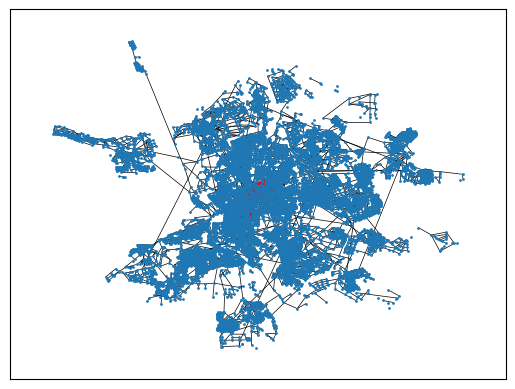

In [142]:
def procesar_direccciones(direccion: str):
    direccion = direccion.replace("Á", "A").replace("É", "E").replace("Í", "I").replace("Ó", "O").replace("Ú", "U").replace("Ü", "U")
    clase = re.search(regex_direcciones, direccion).group(1)
    nombre = re.search(regex_direcciones, direccion).group(3)
    numero = re.search(regex_direcciones, direccion).group(5)
    sufijo = re.search(regex_direcciones, direccion).group(6)

    df_direcc_filtrado = df_direcc[(df_direcc["Clase de la via"] == clase)]
    df_direcc_filtrado = df_direcc_filtrado[(df_direcc_filtrado["Nombre de la vía"] == nombre)]
    df_direcc_filtrado = df_direcc_filtrado[(df_direcc_filtrado["Número"] == int(numero))]
    if sufijo:
        df_direcc_filtrado = df_direcc_filtrado[(df_direcc_filtrado["Sufijo de numeración"] == sufijo)]
    
    coordenadas = df_direcc_filtrado["coordenadas"].unique()[0]
    ID_calle = df_direcc_filtrado["Codigo de via"].unique()[0]

    cruces_calle = calles_dict[ID_calle].cruces

    distancias = {}
    for cruce in cruces_calle:
        distancias[cruce] = dist(coordenadas, cruce)
    distancias = dict(sorted(distancias.items(), key=lambda x: x[1]))
    distancias = list(distancias.keys())
    cruce_mas_cercano = cruces[distancias[0]]
    return cruce_mas_cercano, distancias[0]

def generar_edgelist(camino):
    aristas = []
    for i in range(len(camino)-1):
        aristas.append((camino[i], camino[i+1]))
    return aristas

regex_direcciones = r"([A-ZÁÉÍÓÚÜ]+)\s*(DEL|DE LA|DE LOS|DE LAS|DE)?\s+([A-ZÁÉÍÓÚÜ]-[0-9]+|[A-ZÁÉÍÓÚÜ\s]+),?\s+(NUM|KM)?\s?([0-9]+)([A-Z]{0,2})"

if __name__ == "__main__":

    origen = "origen"
    destino = "destino"

    while True:
        error = True
        while error:
            origen = input("DIRECCIÓN DE ORIGEN: ").upper()
            destino = input("DIRECCIÓN DE DESTINO: ").upper()
            if origen == "" or destino == "":
                break
            
            cruce_origen, coordenadas_origen = procesar_direccciones(origen)
            cruce_destino, coordenadas_destino = procesar_direccciones(destino)

            if cruce_origen and cruce_destino:
                error = False
            else:
                print("ERROR: Alguna dirección es incorrecta.\n")
        if origen == "" or destino == "":
            break

        error = True
        while error:
            modo = input("¿ENCONTRAR RUTA MÁS CORTA O RUTA MÁS RÁPIDA?\nEscribe '1' para ruta más corta, '2' para ruta más rápida: ")
            if modo == '1':
                grafo = grafo_d
                error = False
            elif modo == '2':
                grafo = grafo_t
                error = False
            else:
                print("ERROR: Seleccione un modo correcto.\n")

        # camino = grafo.camino_minimo(cruce_origen, cruce_destino)
        # aristas = generar_edgelist(camino)
        # print(grafo.dijkstra(cruce_origen))
        camino_min = grafo.camino_minimo(cruce_origen, cruce_destino)
        camino_min_aristas = generar_edgelist(camino_min)
        mostrar_ruta(grafo, camino_min_aristas)